# Analiza podatkovne baze $\pi$-base

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import json
%matplotlib inline

barve = mpl.colors.LinearSegmentedColormap.from_list('barve', ( '#aab6fb', '#faa7b8', '#fb7f8e' ))

Za začetek iz direktorije `podatki` naložimo z `main.py`ustvarjene dodateke. Če smo program zagnali večkrat, uporabimo najnovejšo verzijo datotek. Predpostavimo tudi, da smo podatke res naložili v direktorijo. Če nismo, nič hudega, saj so v njej tudi že predpripravljeni (postane).

In [2]:
from analiza import preberi
prostori, prostori_lastnosti, rocno_pregledane_lastnosti, lastnosti, izreki, protiprimeri, sklici = preberi()

Pričnemo z nečim malce bolj dolgočasnim. Recimo, obrat katerega izreka ima največ protiprimerov?

In [3]:
podatki = [ [ x, len([ y for y in protiprimeri[x].values() if y ]) ] for x in protiprimeri ]
df = pd.DataFrame(podatki, columns = [ 'izrek', 'št. protiprimerov' ])
df.sort_values('št. protiprimerov', ascending = False).head(5)

,izrek,št. protiprimerov
570,T000571,186
40,T000041,181
633,T000634,174
448,T000449,171
142,T000143,168


Poglejmo si še, koliko obratov nima protiprimera.

In [4]:
len([ x for x in df['št. protiprimerov'] if not x ])

88

Ali to pomeni, da so te implikacije v resnici ekvivalence? Ne nujno. No morda. Konec koncev naj bi to bila podatkovna baza topoloških protiprimerov in človek bi si predstavljal, da bodo za vsak izrek v bazi imeli vsaj kakšen protiprimer...

Poglejmo si še za kateri prostor največ lastnosti ne velja, potem pa se premaknemo na kakšno bolj zanimivo reč.

In [5]:
podatki = [ [ x, len([ y for y in prostori_lastnosti[x].values() if not y ]) ] for x in prostori_lastnosti ]
df = pd.DataFrame(podatki, columns = [ 'prostor', 'št. lastnosti, ki ne veljajo' ])
df.sort_values('št. lastnosti, ki ne veljajo', ascending = False).head(5)

,prostor,"št. lastnosti, ki ne veljajo"
81,S000082,191
181,S000183,180
128,S000130,179
80,S000081,179
91,S000092,178


## Sklici

Sklici. Zanima nas... Kateri je bil največkrat uporabljen?

In [6]:
sklici.sort_values('skupaj', ascending = False).head(5)

,ime,vrsta,ekstra,št. v prostori,št. v prostori-lastnosti,št. v lastnosti,št. v izreki,skupaj
0,Counterexamples in Topology,doi,10.1007/978-1-4612-6290-9,134,763,57,86,1040
2,General Topology (Willard),zb,1052.54001,2,12,31,30,75
7,"General Topology (Engelking, 1989)",zb,0684.54001,3,7,17,26,53
55,Topology (Munkres),zb,0951.54001,3,3,6,14,26
124,A topological view of P-spaces (A. Misra),doi,10.1016/0016-660X(72)90026-8,2,11,1,7,21


Imamo očitnega zmagovalca. [Counterexamples in Topology Lynna Steena](https://archive.org/details/counterexamplesi0000stee) je daleč, daleč največkrat citirana. Morda bi se hoteli vprašati kako to?, ampak mislim, da je dokaj očitno, zakaj je temu tako. Ta knjiga je seveda glavna inspiracija za podatkovno bazo samo.

Sedaj pa si poglejmo, iz katerega vira je bilo citiranih največ različnih stvari.

In [7]:
viri = dict()
for x, y in zip(sklici['vrsta'], sklici['skupaj']):
    viri.setdefault(x, dict()).setdefault('razlicnih', 0)
    viri[x]['razlicnih'] += 1
    viri[x].setdefault('skupaj', 0)
    viri[x]['skupaj'] += y
podatki = [ ( x, *viri[x].values() ) for x in viri ]
df = pd.DataFrame(podatki, columns = ( 'vir', 'št. različnih', 'št. vseh' ))
df.sort_values('št. različnih', ascending = False)

,vir,št. različnih,št. vseh
3,mathse,271,465
1,wikipedia,138,249
0,doi,112,1341
2,zb,56,268
4,mr,39,66
5,mo,31,54


Izkaže se, da je [stackexchange](math.stackexchange.com) največkrat uporabljen. Posebej presenetljivo je, da se je še vseeno pojavilo toliko različnih člankov in knjig, saj imajo te potencial biti citirani tudi večkrat in to je nekaj, česar za stackexchange objave ali wikipedia članke definitivno ne moremo reči. Kot pričakovano, pa so bile 'doi reči' skupaj citirane daleč največkrat. Seveda če izvzamemo Counterexamples in Topology, temu ni več tako...

## Opisi

No tu pa smo prišli do resnih stvari. Narišimo graf dolžine opisov vseh izrekov.

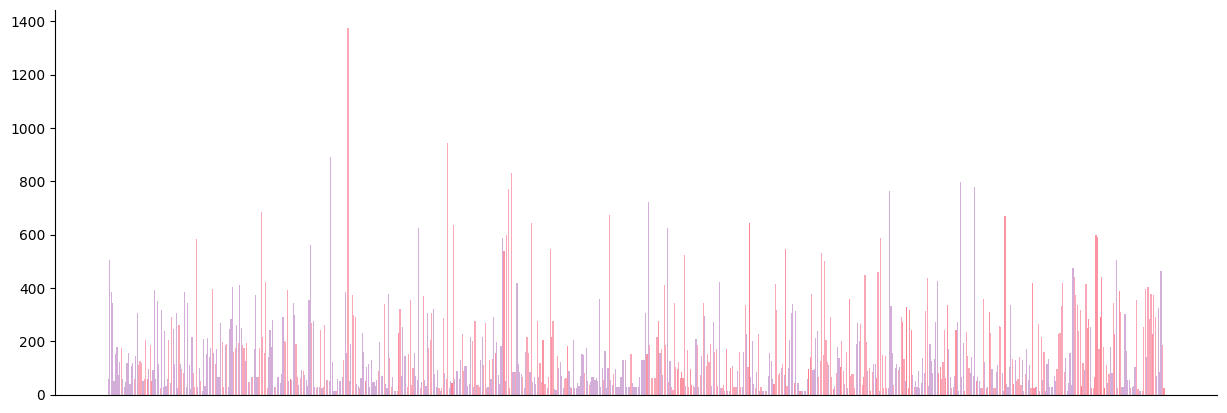

In [8]:
imena = [ x['uid'] for x in izreki ]
dolzine = [ len(x['opis']) for x in izreki ]
m = max(dolzine)
n = max([ len(x['pogoj']) for x in izreki ])
pobarvano = [ barve(len(x['pogoj']) / n) for x in izreki ]

fig, ax = plt.subplots()
ax.bar(imena, dolzine, color = pobarvano)

ax.set_xticks([])
[ ax.spines[x].set_visible(False) for x in ( 'top', 'right' ) ]
fig.set_size_inches(15, 5)
plt.show()

Kot opazimo, graf izgleda zelo lepo. Kaj pa nam pove? Bolj malo. No ja, pove nam, da so nekateri opisi dolgi tudi čez 1000 znakov. To nas motivira, da narišemo grafe še za preostale datoteke, vendar tega ne naredimo, saj bi vzelo preveč časa.

Namesto tega poglejmo, ali obstaja kakšna koleracija med dolžino opisa in številom sklicev...

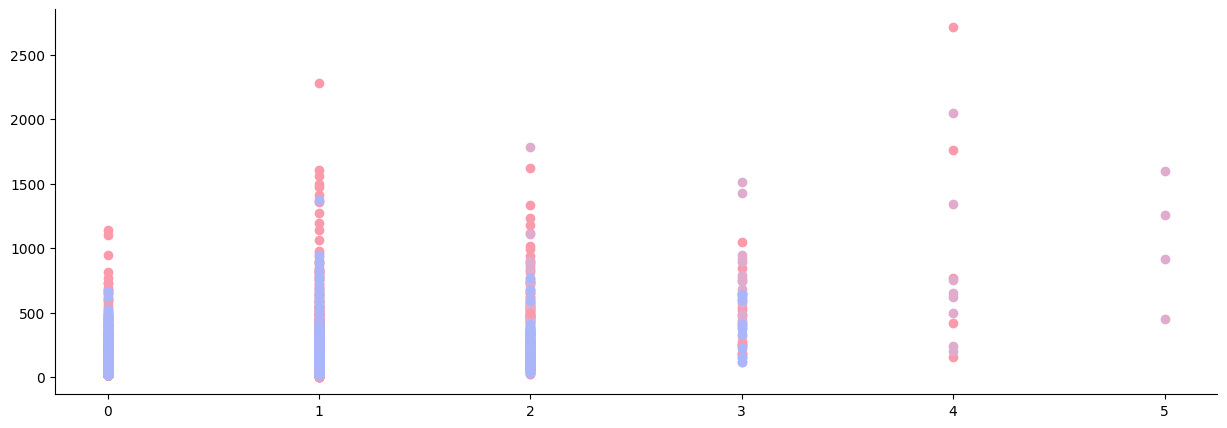

In [9]:
csv_datoteke = ( prostori, lastnosti, rocno_pregledane_lastnosti )
pobarvano = dict(zip([ x.columns[0] for x in csv_datoteke ], [ barve(x / len(csv_datoteke)) for x in range(len(csv_datoteke)) ]))

fig, ax = plt.subplots()
for x in csv_datoteke:
    ax.scatter(x['št. sklicev'], [ len(y) for y in x['opis'] ], color = pobarvano[x.columns[0]])
ax.scatter([ x['št. sklicev'] for x in izreki ], [ len(x['opis']) for x in izreki ], color = barve(1))

[ ax.spines[x].set_visible(False) for x in ( 'top', 'right' ) ]
fig.set_size_inches(15, 5)
plt.show()

Šokantno!!! ne opazimo nobene koleracije. Kdo bi si mislil. Še vseeno zelo zanimivo. Mogoče pa ima dolžina opisa kaj s številom aliasov prostora? Tukaj lahko pregledamo le lastnosti in prostore, ampak to nam vseeno lahko poda veliko informacij... se mi zdi.

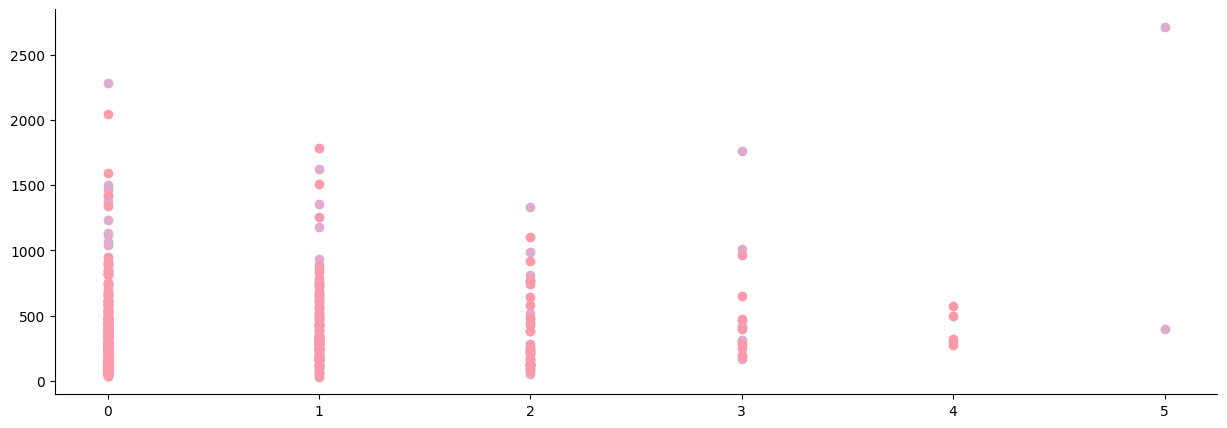

In [10]:
csv_dat = ( prostori, lastnosti )
pobarvano = { prostori.columns[0] : barve(1 / 3), lastnosti.columns[0] : barve(2 / 3) }

fig, ax = plt.subplots()
for x in csv_dat:
    ax.scatter(x['št. aliasov'], [ len(y) for y in x['opis'] ], color = pobarvano[x.columns[0]])

[ ax.spines[x].set_visible(False) for x in ( 'top', 'right' ) ]
fig.set_size_inches(15, 5)
plt.show()

Tudi tu ni nobene koleracije??? Kaj pa zdaj? To popolnoma podre mojo teorijo :/

Morda bi se bilo bolje prestaviti na kakšno bolj konstruktivno reč recimo... Kolikokrat se v opisih izrekov pojavi beseda 'obvious' in podobne, saj so taki, kjer je teh besed veliko, vedno najbolj uporabni in najlepše napisani ter bi si jih v prihodnje želeli imeti več.

In [11]:
import re
vzorci = ( '(O|o)bvious', '(T|t)rivial', '(C|c)lear', '(L|l)eft as an exercise' )
s = { x : len([ y for y in izreki if len(re.findall(x, y['opis'])) ]) for x in vzorci }
n = sum(s.values())
for x in s: print(f'{x:23} {s[x]:{len(str(n))}d}')
print(f'{'skupaj':23} {n}/{len(izreki)}')

(O|o)bvious              1
(T|t)rivial              6
(C|c)lear                3
(L|l)eft as an exercise  0
skupaj                  10/732


Kot lahko vidimo le majhen procent opisov oziroma dokazov izrekov vsebuje iskane besede in besedne zveze. Kakšna škoda!

## Podatkovni bazi ne znano

No za konec pa si še oglejmo koliko lastnosti prostorov nam je ostalo neznanih. To je zanimivo, saj nam poda vpogled v omejitve podatkovne baze.

In [12]:
podatki = [ ( x, len([ y for y in prostori_lastnosti[x] if prostori_lastnosti[x][y] == None ]) ) for x in prostori_lastnosti ]
df = pd.DataFrame(podatki, columns = ( 'prostor', 'št. neznanih' ))
df.sort_values('št. neznanih', ascending = False).head(5)

,prostor,št. neznanih
205,S000207,104
128,S000130,86
179,S000181,84
107,S000109,82
91,S000092,75


Pri nekaterih... No ja. Poglejmo še katerih lastnosti največkrat ni mogoče izpeljati s podanih izrekov v primerjavi s tem, kolikokrat se vsaka pojavi v katerem izmed izrekov, in potem lahko zaključimo s par grafi in to je to...

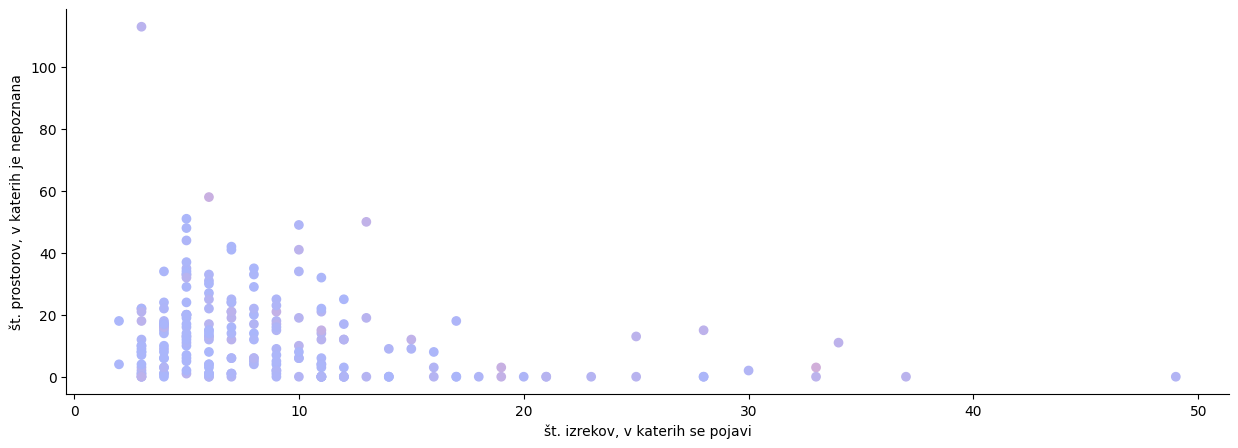

In [13]:
def sePojaviV(lastnost, izrek):
    return lastnost in [ x['lastnost'] for x in izrek['pogoj'] ] or lastnost == izrek['posledica']['lastnost']
            
pobarvano = [ barve(len([ y for y in rocno_pregledane_lastnosti['lastnost'] if y == x ]) / len(prostori['uid'])) for x in lastnosti['uid'] ]

fig, ax = plt.subplots()
se_pojavi = [ len([ y for y in izreki if sePojaviV(x, y) ]) for x in lastnosti['uid'] ]
je_neznana = [ len([ y for y in prostori['uid'] if prostori_lastnosti[y][x] == None ]) for x in lastnosti['uid'] ]
ax.scatter(se_pojavi, je_neznana, color = pobarvano)

ax.set_xlabel('št. izrekov, v katerih se pojavi')
ax.set_ylabel('št. prostorov, v katerih je nepoznana')
[ ax.spines[x].set_visible(False) for x in ( 'top', 'right' ) ]
fig.set_size_inches(15, 5)
plt.show()

Kakšno presenečenje! Lastnosti, ki se pojavijo v več izrekih, so manjkrat neznane??? Kdo bi si mislil??

## Vizualizacije

Zdaj pa samo še obljubljene vizualizacije. Zanje uporabimo knjižnico `networkx`, ki nam pomaga vizualizirati grafe.

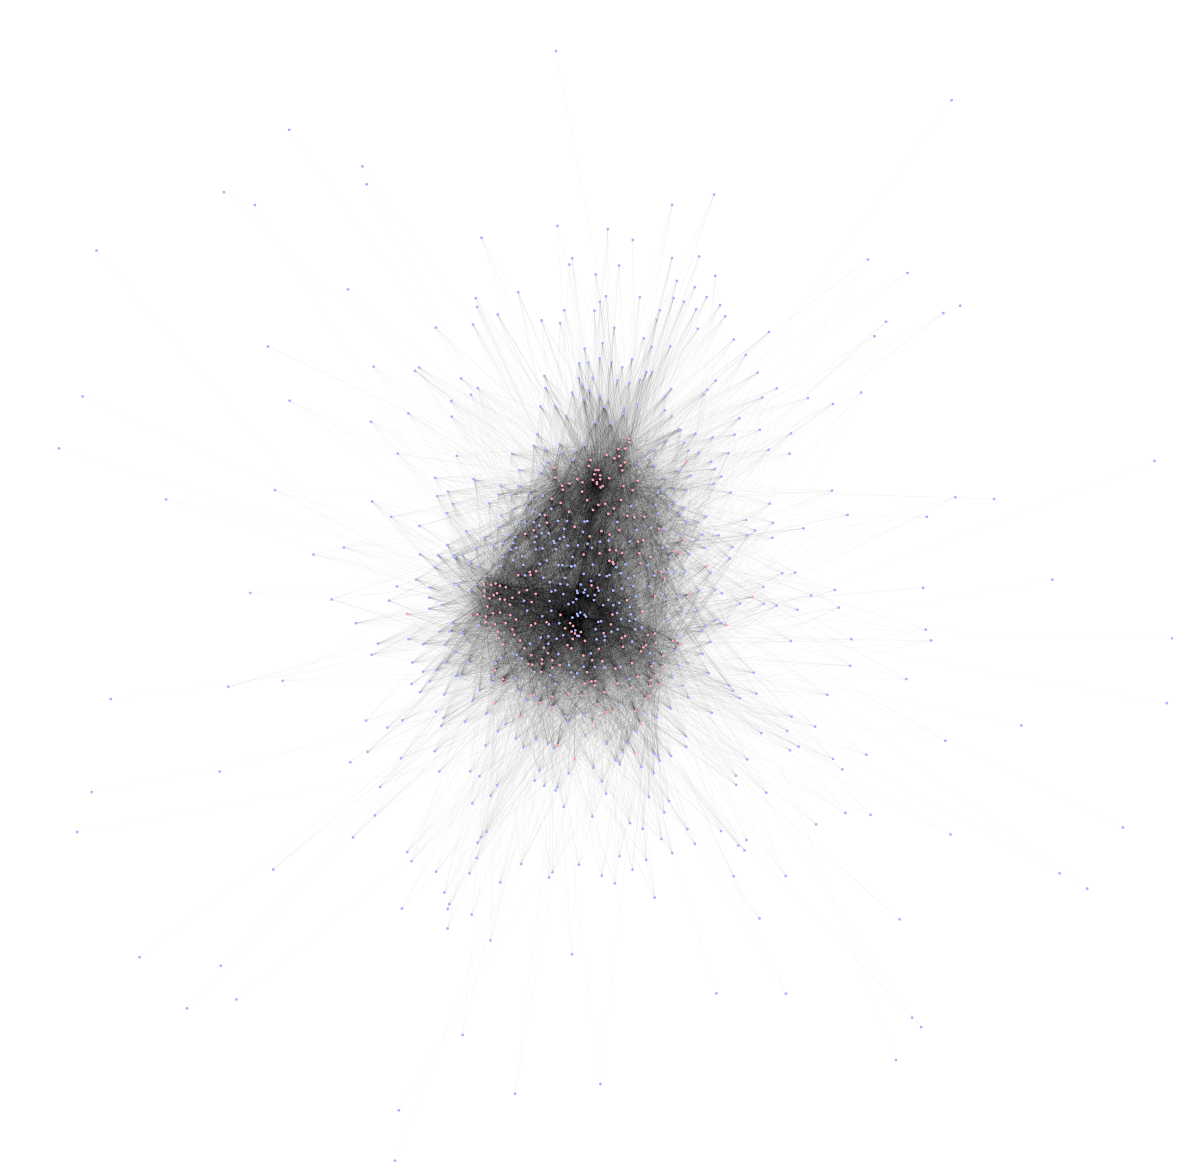

In [14]:
import networkx as nx

robovi = []
for x in izreki: robovi += [ ( x['uid'], y ) for y in protiprimeri[x['uid']] if protiprimeri[x['uid']][y] ]

fig, ax = plt.subplots()
G = nx.Graph()
G.add_edges_from(robovi)
pos = nx.spring_layout(G)
pobarvano = [ barve(0.5) if x[0] == 'S' else barve(1) for x in G ]
nx.draw_networkx_edges(G, pos, width = 0.01)
nx.draw_networkx_nodes(G, pos, node_color = pobarvano, node_size = 1)

ax.set_xlim(( -1, 1 ))
ax.set_ylim(( -1, 1 ))
plt.axis('off')
fig.set_size_inches(15, 15)
plt.show()

To izgleda kar vredu. Kaj pa še ena? Tokrat se lotimo prostorov...

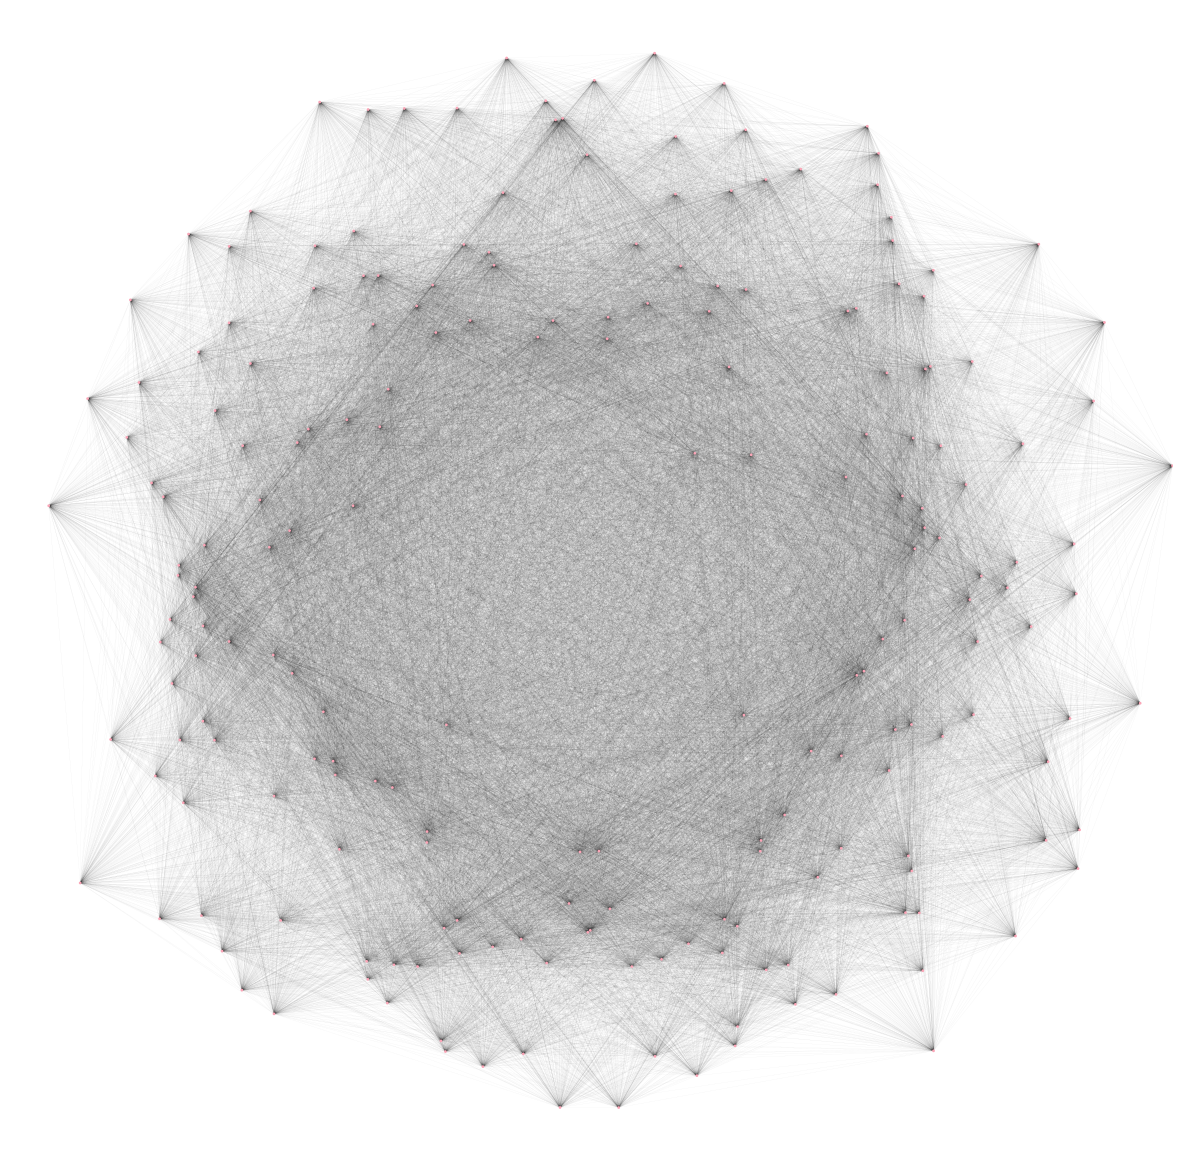

In [15]:
import networkx as nx
import itertools as it

def teza(x, y, lastnosti): return len([ x for x in lastnosti if lastnosti[x] and lastnosti[y] ]) / len(lastnosti[x])

fig, ax = plt.subplots()
G = nx.Graph()

for x, y in it.combinations(prostori['uid'], 2):
    if (t := teza(x, y, prostori_lastnosti)) >= 0.5: G.add_edge(x, y, weigth = t)
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_edges(G, pos, edge_color = 'black', width = 0.01)
pobarvano = [ barve(0.5) for x in G ]
nx.draw_networkx_nodes(G, pos, node_size = 1, node_color = pobarvano)

ax.set_xlim(( -1, 1 ))
ax.set_ylim(( -1, 1 ))
plt.axis('off')
fig.set_size_inches(15, 15)
plt.show()

## Zaključek

Merci de m'avoir lu.